## NOTE
As the dataset is in jpeg format respectively the dataset is unable to be uploaded to Github due to the size of the dataset. The dataset can be retrieved in Kaggle as stated in the References.This is the link to the dataset. Download it and put it in the same folder of the Jupyter notebook and it will work right away. https://www.kaggle.com/datasets/ayuraj/asl-dataset?resource=download

# American Sign Language Recognition using PyTorch

This notebook implements a deep learning system for recognizing American Sign Language (ASL) gestures. 
We'll compare two different model architectures:
1. A simple sequential model
2. A more complex model with attention mechanism for RGB channels

The notebook demonstrates:
- Custom dataset creation
- Model architecture design
- Training and evaluation
- Performance visualization and analysis

## 1. Setup and Imports
First, let's import all necessary libraries and set up our environment

In [17]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import os
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 2. Custom Dataset Implementation
We implement a custom Dataset class for ASL images that:
- Creates a mapping for labels (0-9, a-z)
- Loads images from the directory structure
- Provides methods to access images and their labels

The dataset expects a directory structure where each subdirectory is named after the label (0-9, a-z)
and contains the corresponding images.

In [2]:
class ASLDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all image files and labels
        self.image_files = []
        self.labels = []
        
        # Create label mapping (0-9, a-z)
        self.label_to_idx = {}
        # Add numbers (0-9)
        for i in range(10):
            self.label_to_idx[str(i)] = i
        # Add letters (a-z) starting from index 10
        for i, letter in enumerate(range(ord('a'), ord('z') + 1)):
            self.label_to_idx[chr(letter)] = i + 10
            
        # Walk through the directory structure
        for label in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path) and label in self.label_to_idx:
                label_idx = self.label_to_idx[label]
                for img_file in os.listdir(label_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_files.append(os.path.join(label_path, img_file))
                        self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image in color (RGB)
        image_path = self.image_files[idx]
        image = Image.open(image_path)  # Keep RGB channels
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]
    
    def get_label_name(self, idx):
        if idx < 10:
            return str(idx)
        else:
            return chr(ord('a') + (idx - 10))

## 3. Model Architectures

### 3.1 Sequential Model
This is a simple feedforward neural network that:
- Flattens the input image
- Processes it through several linear layers with ReLU activation
- Uses dropout and batch normalization for regularization

In [3]:
def create_sequential_model():
    return nn.Sequential(
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(28*28*3, 256),  # 3 channels * 28 * 28
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3),
        nn.Linear(128, 36),
        nn.LogSoftmax(dim=1)
    )

### 3.2 Complex Model with Attention
This model uses a more sophisticated architecture that:
- Processes each RGB channel separately
- Uses an attention mechanism to weight channel importance
- Combines features through a fusion layer

In [4]:
# Updated ASLNet with CNN-based architecture
class ASLNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extraction for each channel
        self.feature_extract = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        
        # Feature dimension after CNN processing
        self.cnn_output_size = 32 * 7 * 7
        
        # Shared features processing
        self.shared = nn.Sequential(
            nn.Linear(self.cnn_output_size * 3, 256),  # 3 channels combined
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )
        
        # Channel attention
        self.attention = nn.Sequential(
            nn.Linear(256, 3),  # One weight per channel
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 36)
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Process each channel separately
        r = self.feature_extract(x[:, 0:1, :, :])  # Red channel
        g = self.feature_extract(x[:, 1:2, :, :])  # Green channel
        b = self.feature_extract(x[:, 2:3, :, :])  # Blue channel
        
        # Flatten and concatenate features
        r_flat = r.view(batch_size, -1)
        g_flat = g.view(batch_size, -1)
        b_flat = b.view(batch_size, -1)
        
        combined = torch.cat([r_flat, g_flat, b_flat], dim=1)
        
        # Process through shared layers
        features = self.shared(combined)
        
        # Apply attention
        channel_weights = self.attention(features)
        attended_features = features * channel_weights.mean(dim=1, keepdim=True)
        
        # Final classification
        logits = self.classifier(attended_features)
        return F.log_softmax(logits, dim=1)

## 4. Data Loading and Preprocessing

Let's set up our data pipeline with:
- Appropriate image transformations
- Dataset splitting into train/test sets
- DataLoader creation for batch processing

In [5]:
def load_asl_data(data_dir, train_split=0.8):
    """Load and split ASL dataset"""
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats for RGB
                           std=[0.229, 0.224, 0.225])
    ])
    
    full_dataset = ASLDataset(data_dir, transform=transform)
    
    train_size = int(train_split * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    train_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, test_size]
    )
    
    print(f"Total dataset size: {len(full_dataset)}")
    print(f"Training data size: {len(train_dataset)}")
    print(f"Testing data size: {len(test_dataset)}")
    
    return train_dataset, test_dataset

# Load the data
data_dir = "asl_dataset"  # Update this path to your dataset location
train_data, test_data = load_asl_data(data_dir)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

Total dataset size: 2515
Training data size: 2012
Testing data size: 503


## 5. Data Visualization

Let's visualize some sample images from our dataset to ensure proper loading and preprocessing

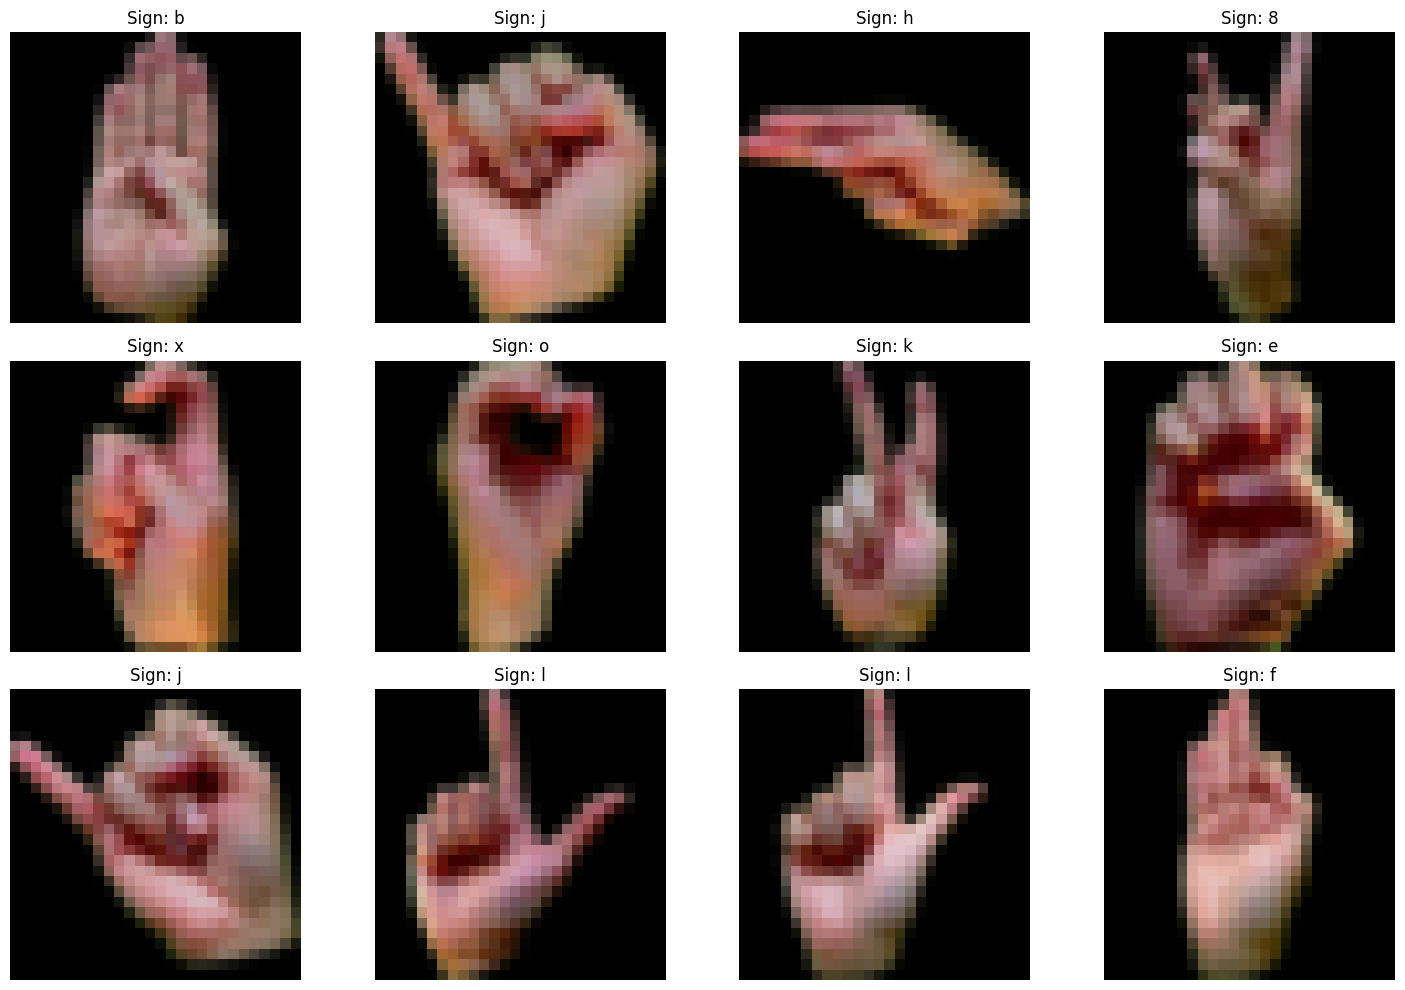

In [6]:
def visualize_data_samples(dataloader, dataset):
    """Visualize sample images with their labels"""
    plt.figure(figsize=(15, 10))
    images, targets = next(iter(dataloader))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        label_name = dataset.dataset.get_label_name(targets[i].item())
        plt.title(f'Sign: {label_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_data_samples(train_loader, train_data)

## 6. Model Training

We'll define a comprehensive training function that:
- Handles both training and validation
- Implements learning rate scheduling
- Tracks various metrics
- Provides detailed progress updates

In [7]:
def train_model(model, train_data, test_data, epochs=20, model_name="Model"):
    model = model.to(device)
    
    criterion = nn.NLLLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                            epochs=epochs,
                                            steps_per_epoch=len(DataLoader(train_data, batch_size=64)))
    
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64)
    
    metrics = {
        'train_losses': [],
        'test_losses': [],
        'test_accuracies': [],
        'learning_rates': [],
        'epoch_times': []
    }
    
    best_acc = 0
    
    for epoch in range(epochs):
        epoch_start = timer()
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        # Training phase
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 20 == 0:
                print(f'{model_name} Epoch {epoch}: '
                      f'[{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                      f'Loss: {loss.item():.4f}')
        
        # Calculate average training loss
        avg_train_loss = train_loss / num_batches
        
        # Testing phase
        model.eval()
        test_loss = 0
        correct = 0
        num_test_batches = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                num_test_batches += 1
        
        avg_test_loss = test_loss / num_test_batches
        accuracy = 100. * correct / len(test_loader.dataset)
        epoch_time = timer() - epoch_start
        
        scheduler.step(accuracy)
        
        # Store metrics
        metrics['train_losses'].append(avg_train_loss)
        metrics['test_losses'].append(avg_test_loss)
        metrics['test_accuracies'].append(accuracy)
        metrics['learning_rates'].append(optimizer.param_groups[0]['lr'])
        metrics['epoch_times'].append(epoch_time)
        
        print(f'\n{model_name} Epoch {epoch} Summary:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Test Loss: {avg_test_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f'Time: {epoch_time:.2f}s\n')
        
        if accuracy > best_acc:
            best_acc = accuracy
            print(f'New best accuracy: {best_acc:.2f}%')
    
    return metrics

## Training Sequential Model

In [8]:
print("Training Sequential Model...")
sequential_model = create_sequential_model()
sequential_metrics = train_model(sequential_model, train_data, test_data,
                               epochs=10, model_name="Sequential")

Training Sequential Model...
Sequential Epoch 0: [0/2012 (0%)]	Loss: 3.6845
Sequential Epoch 0: [1280/2012 (62%)]	Loss: 2.9800


/Users/mystic/Desktop/Everything/Uni/Machine Learning/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Sequential Epoch 0 Summary:
Training Loss: 3.2405
Test Loss: 2.8481
Test Accuracy: 40.16%
Learning Rate: 0.000405
Time: 2.65s

New best accuracy: 40.16%
Sequential Epoch 1: [0/2012 (0%)]	Loss: 2.7653
Sequential Epoch 1: [1280/2012 (62%)]	Loss: 1.9324

Sequential Epoch 1 Summary:
Training Loss: 2.0752
Test Loss: 1.4514
Test Accuracy: 77.34%
Learning Rate: 0.000920
Time: 1.93s

New best accuracy: 77.34%
Sequential Epoch 2: [0/2012 (0%)]	Loss: 1.5812
Sequential Epoch 2: [1280/2012 (62%)]	Loss: 1.1316

Sequential Epoch 2 Summary:
Training Loss: 1.2122
Test Loss: 0.9146
Test Accuracy: 82.90%
Learning Rate: 0.000962
Time: 1.88s

New best accuracy: 82.90%
Sequential Epoch 3: [0/2012 (0%)]	Loss: 0.9338
Sequential Epoch 3: [1280/2012 (62%)]	Loss: 0.7343

Sequential Epoch 3 Summary:
Training Loss: 0.7706
Test Loss: 0.6710
Test Accuracy: 82.90%
Learning Rate: 0.000962
Time: 1.89s

Sequential Epoch 4: [0/2012 (0%)]	Loss: 0.4820
Sequential Epoch 4: [1280/2012 (62%)]	Loss: 0.4991

Sequential Epoch 

## Training nn.Module Model

In [9]:
print("Training nn.Module Model...")
module_model = ASLNet()
module_metrics = train_model(module_model, train_data, test_data,
                           epochs=10, model_name="nn.Module")

Training nn.Module Model...
nn.Module Epoch 0: [0/2012 (0%)]	Loss: 3.8185
nn.Module Epoch 0: [1280/2012 (62%)]	Loss: 3.0044

nn.Module Epoch 0 Summary:
Training Loss: 3.1940
Test Loss: 2.7609
Test Accuracy: 52.09%
Learning Rate: 0.000593
Time: 4.08s

New best accuracy: 52.09%
nn.Module Epoch 1: [0/2012 (0%)]	Loss: 2.5431
nn.Module Epoch 1: [1280/2012 (62%)]	Loss: 1.4093

nn.Module Epoch 1 Summary:
Training Loss: 1.6611
Test Loss: 0.8620
Test Accuracy: 86.68%
Learning Rate: 0.000982
Time: 3.69s

New best accuracy: 86.68%
nn.Module Epoch 2: [0/2012 (0%)]	Loss: 0.9902
nn.Module Epoch 2: [1280/2012 (62%)]	Loss: 0.6183

nn.Module Epoch 2 Summary:
Training Loss: 0.7879
Test Loss: 0.4811
Test Accuracy: 90.26%
Learning Rate: 0.000994
Time: 3.44s

New best accuracy: 90.26%
nn.Module Epoch 3: [0/2012 (0%)]	Loss: 0.5121
nn.Module Epoch 3: [1280/2012 (62%)]	Loss: 0.3739

nn.Module Epoch 3 Summary:
Training Loss: 0.3684
Test Loss: 0.3080
Test Accuracy: 94.83%
Learning Rate: 0.001000
Time: 3.43s

Ne

## 7. Results Analysis and Visualization

Now let's analyze the performance of both models through various visualizations

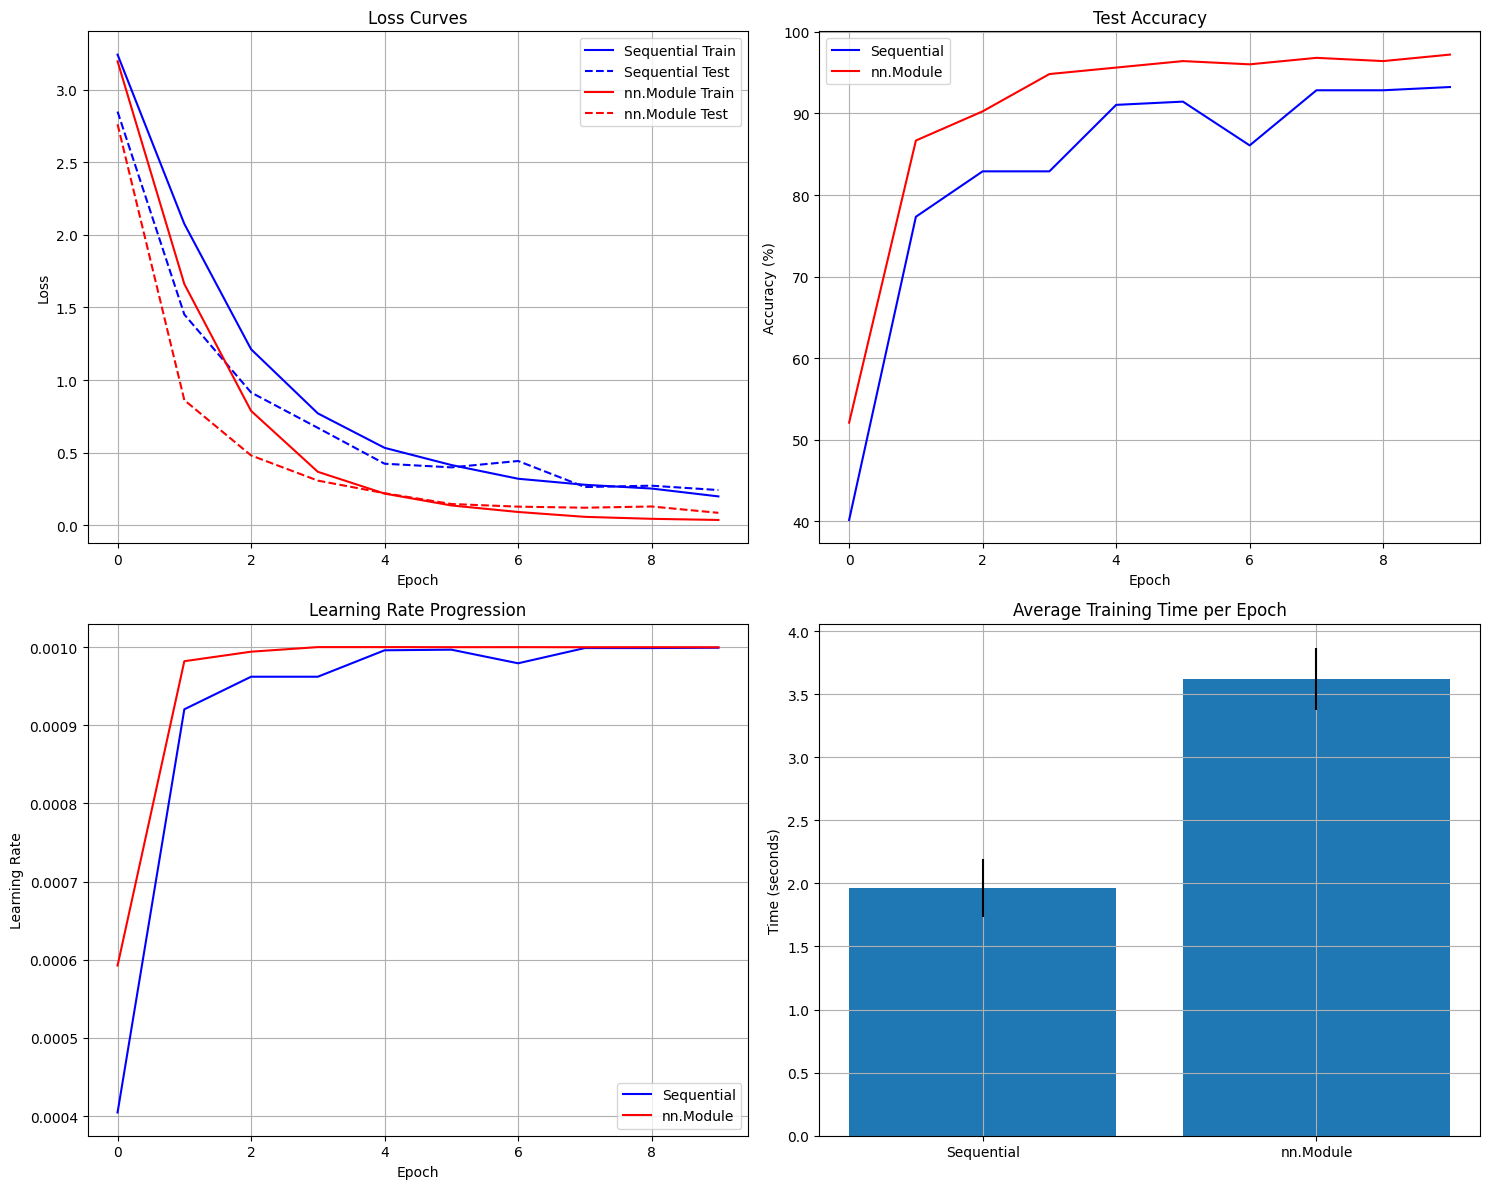

In [10]:
def plot_training_metrics(sequential_metrics, module_metrics):
    """Plot comprehensive training metrics comparison"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot training losses
    ax1.plot(sequential_metrics['train_losses'], 'b-', label='Sequential Train')
    ax1.plot(sequential_metrics['test_losses'], 'b--', label='Sequential Test')
    ax1.plot(module_metrics['train_losses'], 'r-', label='nn.Module Train')
    ax1.plot(module_metrics['test_losses'], 'r--', label='nn.Module Test')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot test accuracies
    ax2.plot(sequential_metrics['test_accuracies'], 'b-', label='Sequential')
    ax2.plot(module_metrics['test_accuracies'], 'r-', label='nn.Module')
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rates
    ax3.plot(sequential_metrics['learning_rates'], 'b-', label='Sequential')
    ax3.plot(module_metrics['learning_rates'], 'r-', label='nn.Module')
    ax3.set_title('Learning Rate Progression')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.legend()
    ax3.grid(True)
    
    # Plot training times
    ax4.bar(['Sequential', 'nn.Module'], 
            [np.mean(sequential_metrics['epoch_times']),
             np.mean(module_metrics['epoch_times'])],
            yerr=[np.std(sequential_metrics['epoch_times']),
                  np.std(module_metrics['epoch_times'])])
    ax4.set_title('Average Training Time per Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training metrics
plot_training_metrics(sequential_metrics, module_metrics)

### 7.1 Confusion Matrix Analysis
Let's analyze the models' performance across different classes using confusion matrices

Sequential Model Confusion Matrix:


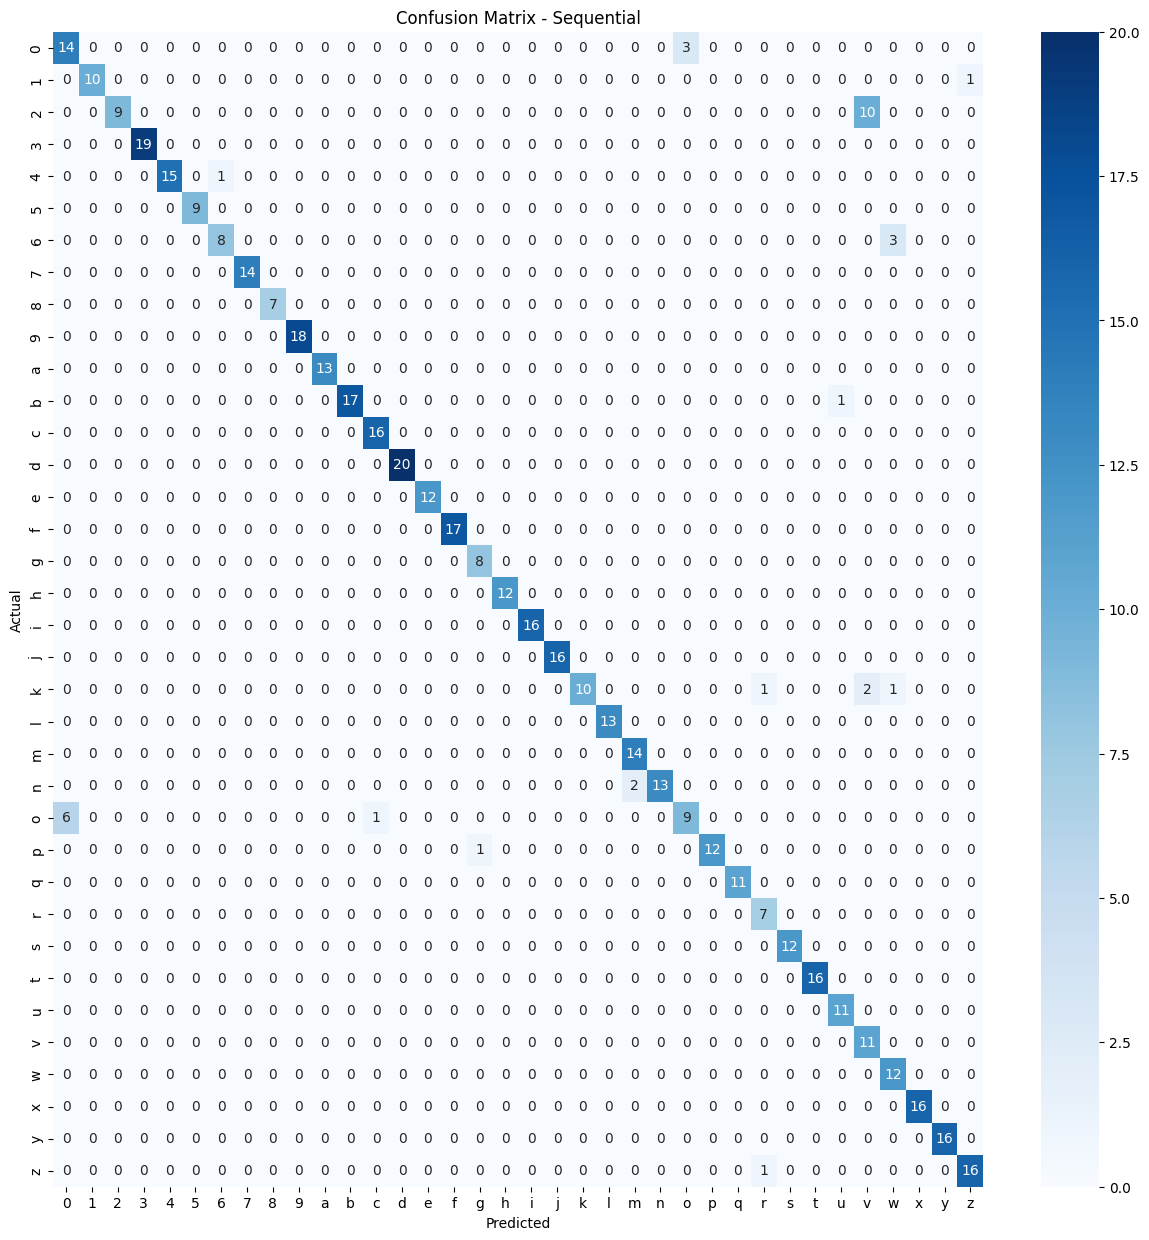


nn.Module Model Confusion Matrix:


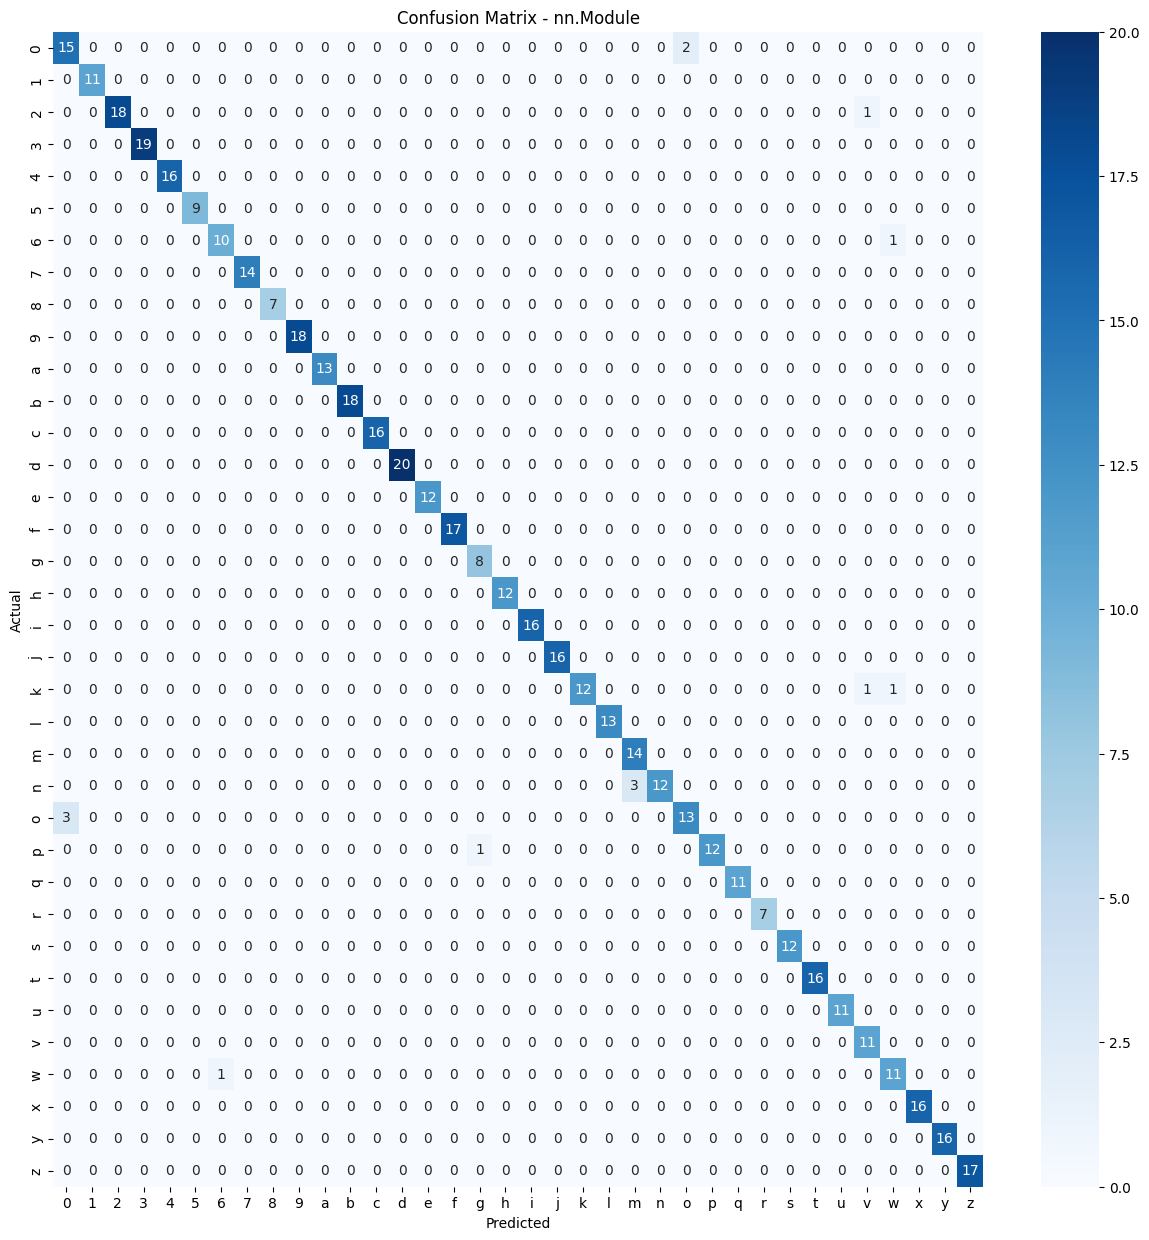

In [12]:
def plot_confusion_matrix(model, test_loader, dataset, num_classes=36, model_name="Model"):
    """Plot confusion matrix for model evaluation"""
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(15, 15))
    
    # Create labels (0-9, a-z)
    labels = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]
    
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for both models
print("Sequential Model Confusion Matrix:")
plot_confusion_matrix(sequential_model, test_loader, test_data, model_name="Sequential")

print("\nnn.Module Model Confusion Matrix:")
plot_confusion_matrix(module_model, test_loader, test_data, model_name="nn.Module")

### 7.2 Per-Class Accuracy Comparison
Compare how well each model performs on individual classes

Comparing per-class accuracy...


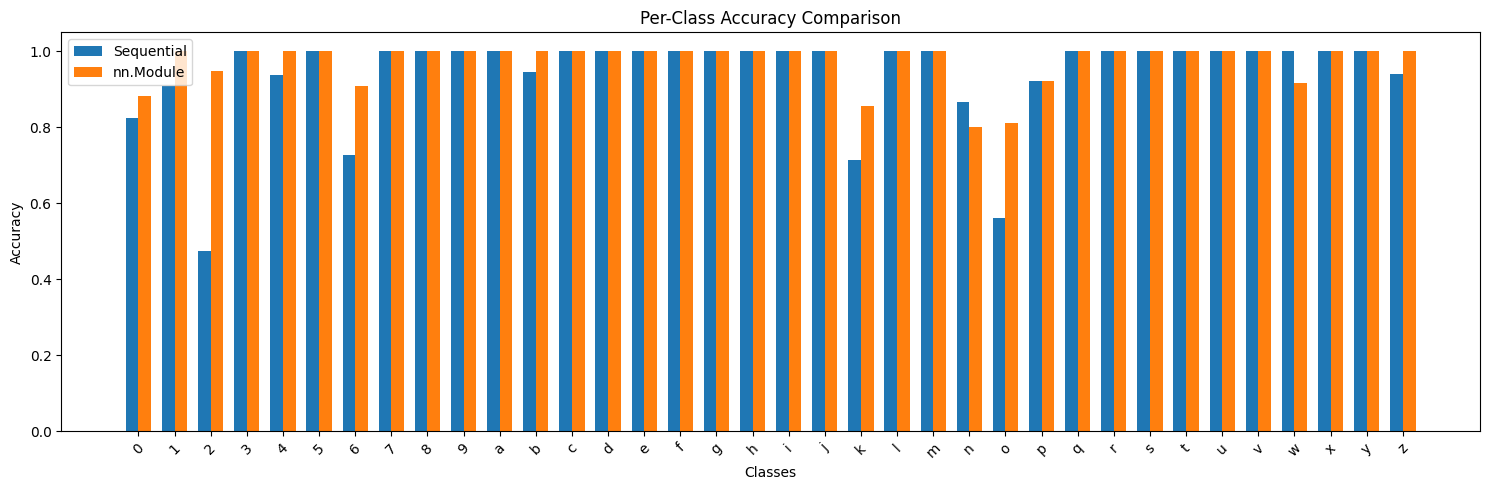

In [14]:
def compare_per_class_accuracy(sequential_model, module_model, test_loader):
    """Compare per-class accuracy between models"""
    def get_class_accuracy(model):
        model.eval()
        class_correct = torch.zeros(36)
        class_total = torch.zeros(36)
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                for t, p in zip(target, pred):
                    if t == p:
                        class_correct[t] += 1
                    class_total[t] += 1
        
        return (class_correct / class_total).cpu().numpy()

    seq_acc = get_class_accuracy(sequential_model)
    mod_acc = get_class_accuracy(module_model)
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    x = np.arange(36)
    width = 0.35
    plt.bar(x - width/2, seq_acc, width, label='Sequential')
    plt.bar(x + width/2, mod_acc, width, label='nn.Module')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy Comparison')
    plt.legend()
    
    # Add labels
    labels = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z')+1)]
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()
    
    return seq_acc, mod_acc

# Compare per-class accuracy
print("Comparing per-class accuracy...")
seq_acc, mod_acc = compare_per_class_accuracy(sequential_model, module_model, test_loader)

### 7.3 Channel Attention Analysis
For the nn.Module model, let's analyze how it weights different color channels

Visualizing channel attention for nn.Module model...


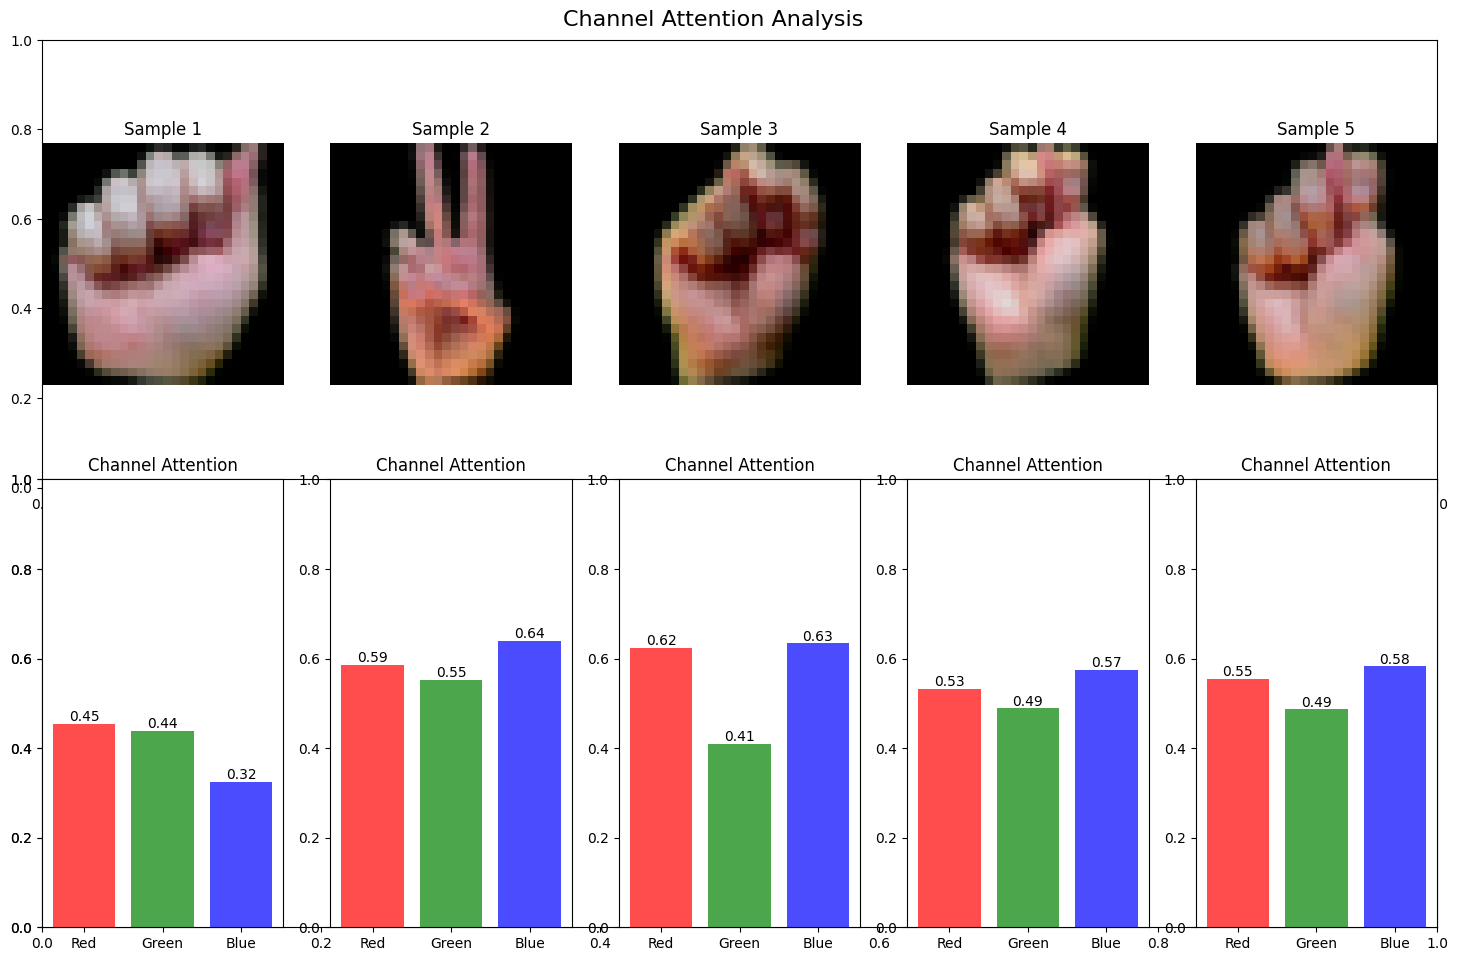

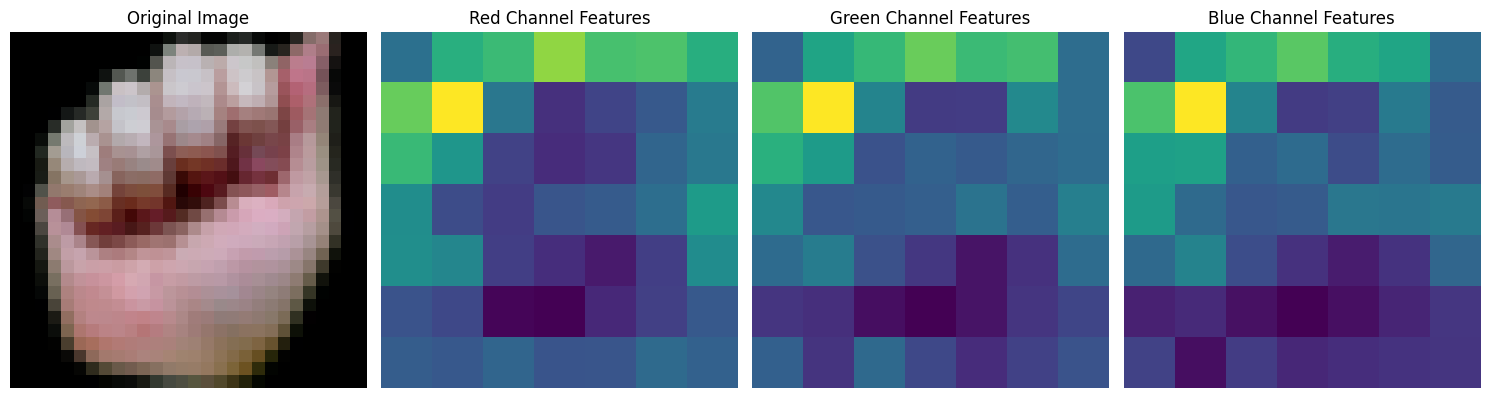

In [15]:
def visualize_channel_attention(model, data_loader):
    """
    Visualize the attention weights that the model assigns to each RGB channel.
    Shows how the model prioritizes different color channels for classification.
    """
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)
    batch_size = images.size(0)
    
    with torch.no_grad():
        # Process images through the model up to attention
        r = model.feature_extract(images[:, 0:1, :, :])  # Red channel
        g = model.feature_extract(images[:, 1:2, :, :])  # Green channel
        b = model.feature_extract(images[:, 2:3, :, :])  # Blue channel
        
        # Flatten and concatenate
        r_flat = r.view(batch_size, -1)
        g_flat = g.view(batch_size, -1)
        b_flat = b.view(batch_size, -1)
        
        combined = torch.cat([r_flat, g_flat, b_flat], dim=1)
        features = model.shared(combined)
        attention_weights = model.attention(features)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle('Channel Attention Analysis', fontsize=16)
    
    # Plot original images
    for i in range(min(5, batch_size)):
        plt.subplot(2, 5, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'Sample {i+1}')
        plt.axis('off')
    
    # Plot attention weights
    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']
    for i in range(min(5, batch_size)):
        plt.subplot(2, 5, i + 6)
        weights = attention_weights[i].cpu().numpy()
        bars = plt.bar(channels, weights, color=colors, alpha=0.7)
        plt.title(f'Channel Attention')
        plt.ylim(0, 1)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    return attention_weights.cpu().numpy()

# Visualize channel attention
print("Visualizing channel attention for nn.Module model...")
visualize_channel_attention(module_model, test_loader)

def visualize_features(model, data_loader):
    """
    Visualize the CNN feature maps for each channel to understand
    what patterns the model is detecting.
    """
    model.eval()
    images, _ = next(iter(data_loader))
    image = images[0:1].to(device)  # Take first image
    
    with torch.no_grad():
        # Get feature maps for each channel
        r_features = model.feature_extract(image[:, 0:1, :, :])
        g_features = model.feature_extract(image[:, 1:2, :, :])
        b_features = model.feature_extract(image[:, 2:3, :, :])
    
    # Visualization setup
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    img = image[0].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Show feature maps
    feature_maps = [r_features, g_features, b_features]
    titles = ['Red Channel Features', 'Green Channel Features', 'Blue Channel Features']
    
    for idx, (feat_map, title) in enumerate(zip(feature_maps, titles)):
        plt.subplot(1, 4, idx + 2)
        # Show mean activation across all feature maps
        mean_activation = feat_map[0].mean(dim=0).cpu().numpy()
        plt.imshow(mean_activation, cmap='viridis')
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Then visualize the feature maps
visualize_features(module_model, test_loader)

## 8. Final Results Summary
Let's compile all our results and compare the models

In [16]:
print("=== Final Model Comparison ===")
print("\nSequential Model:")
print(f"Best Accuracy: {max(sequential_metrics['test_accuracies']):.2f}%")
print(f"Final Training Loss: {sequential_metrics['train_losses'][-1]:.4f}")
print(f"Final Test Loss: {sequential_metrics['test_losses'][-1]:.4f}")
print(f"Average Epoch Time: {np.mean(sequential_metrics['epoch_times']):.2f}s")

print("\nnn.Module Model:")
print(f"Best Accuracy: {max(module_metrics['test_accuracies']):.2f}%")
print(f"Final Training Loss: {module_metrics['train_losses'][-1]:.4f}")
print(f"Final Test Loss: {module_metrics['test_losses'][-1]:.4f}")
print(f"Average Epoch Time: {np.mean(module_metrics['epoch_times']):.2f}s")

# Calculate improvement
seq_best = max(sequential_metrics['test_accuracies'])
mod_best = max(module_metrics['test_accuracies'])
improvement = mod_best - seq_best
print(f"\nAccuracy Improvement: {improvement:.2f}%")

=== Final Model Comparison ===

Sequential Model:
Best Accuracy: 93.24%
Final Training Loss: 0.1992
Final Test Loss: 0.2429
Average Epoch Time: 1.96s

nn.Module Model:
Best Accuracy: 97.22%
Final Training Loss: 0.0371
Final Test Loss: 0.0861
Average Epoch Time: 3.62s

Accuracy Improvement: 3.98%


## REFERENCE
[Ayush Thakur]. (2019). [American Sign Language Dataset], [Version 1], https://www.kaggle.com/datasets/ayuraj/asl-dataset?resource=download